[✓] INS-W_319 – HBOS: 97 rows  ->  data/processed/anomaly_daily/INS-W_319_HBOS.csv


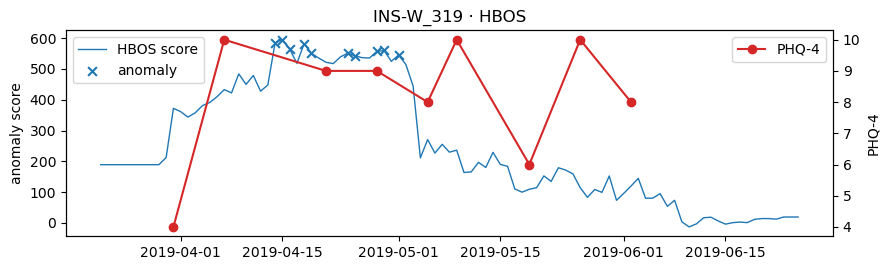

[✓] INS-W_319 – COPOD: 97 rows  ->  data/processed/anomaly_daily/INS-W_319_COPOD.csv


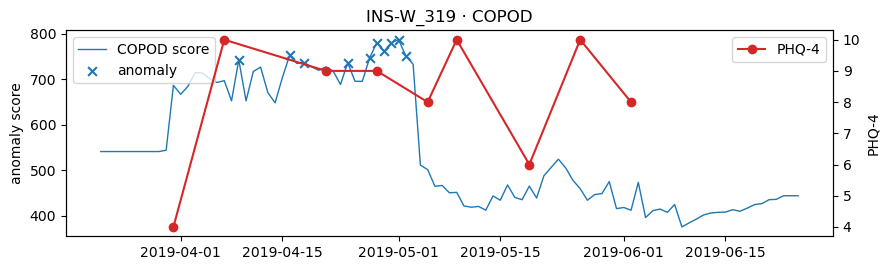

[✓] INS-W_326 – HBOS: 97 rows  ->  data/processed/anomaly_daily/INS-W_326_HBOS.csv


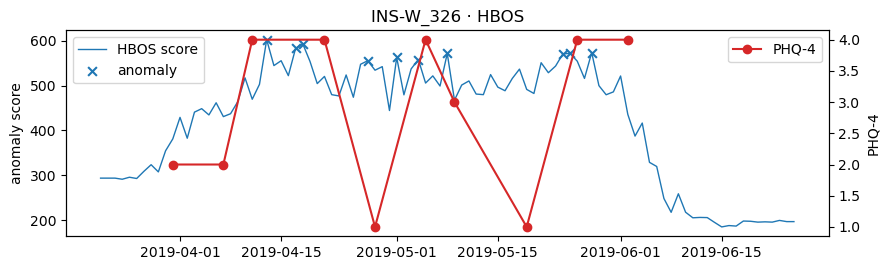

[✓] INS-W_326 – COPOD: 97 rows  ->  data/processed/anomaly_daily/INS-W_326_COPOD.csv


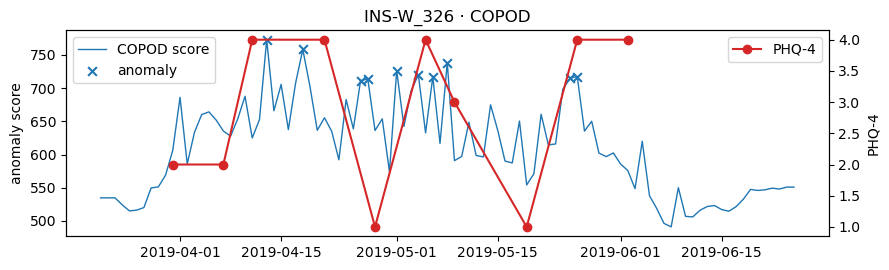

Done in 26.6s


In [5]:
#!/usr/bin/env python3
"""
Daily-level anomaly detection demo on INS-W_2 subjects
-----------------------------------------------------
▪ Uses HBOS and COPOD (PyOD) per subject
▪ Saves <pid>_<model>.csv with "date,score,flag"
▪ Easily extensible: tweak INCLUDE_RE / EXCLUDE_SUBSTRS
"""

# ------------------------------------------------------------------ #
# 0. Imports & basic config
# ------------------------------------------------------------------ #
import os, re, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from functools import lru_cache
from sklearn.preprocessing import RobustScaler
from pyod.models.hbos  import HBOS
from pyod.models.copod import COPOD          # pip install pyod

# ---------- paths -------------------------------------------------- #
DATA_ROOT   = "data/globem_raw"
FOLDER      = "INS-W_2"                      # only year-2 for now
LABEL_FILE  = "dep_weekly.csv"
FEATURE_FILE= "rapids.csv"

# ---------- “good” vs. “bad” column patterns ---------------------- #
INCLUDE_RE  = r"^(?:f_slp:fitbit|f_steps:fitbit|f_screen:phone)"
EXCLUDE_SUBSTRS = [
    "_norm", "_dis", "_7dhist", "_14dhist",
    "weekday", "weekend",
]
EXCLUDE_RE  = "|".join(map(re.escape, EXCLUDE_SUBSTRS))

# ---------- demo subjects to run ---------------------------------- #
DEMO_PIDS   = ["INS-W_319", "INS-W_326"]      # <- swap to your IDs
OUTDIR      = "data/processed/anomaly_daily"
os.makedirs(OUTDIR, exist_ok=True)

# ------------------------------------------------------------------ #
# 1.  File loaders  (cached – reused across subjects)
# ------------------------------------------------------------------ #
@lru_cache(maxsize=4)
def load_rapids(folder: str) -> pd.DataFrame:
    path = os.path.join(DATA_ROOT, folder, "FeatureData", FEATURE_FILE)
    return pd.read_csv(path, low_memory=False)

@lru_cache(maxsize=4)
def load_labels(folder: str) -> pd.DataFrame:
    path = os.path.join(DATA_ROOT, folder, "SurveyData", LABEL_FILE)
    return pd.read_csv(path, low_memory=False)

# ------------------------------------------------------------------ #
# 2.  Build per-day feature matrix for one subject  (NaN-safe)
# ------------------------------------------------------------------ #
def get_daily_matrix(pid: str, folder: str = FOLDER):
    feats = load_rapids(folder)
    df    = feats.loc[feats.pid == pid].copy()

    # 1) keep wanted columns only
    good   = df.columns.str.contains(INCLUDE_RE, regex=True)
    bad    = df.columns.str.contains(EXCLUDE_RE, regex=True)
    use_cols = df.columns[good & ~bad]

    if use_cols.empty:
        raise ValueError(f"No usable columns for {pid}")

    # 2) tidy → date index
    df = df[["date"] + use_cols.tolist()]
    df["date"] = pd.to_datetime(df["date"])
    df.sort_values("date", inplace=True)
    df.set_index("date", inplace=True)

    # 3) numeric block ------------------------------------------------
    num = df.select_dtypes("number")

    # ▸ drop columns that are all-NaN
    num = num.loc[:, ~num.isna().all()]
    if num.shape[1] == 0:
        raise ValueError(f"All numeric columns empty after NaN check for {pid}")

    # ▸ linear interpolation down the time axis, both directions
    num = num.interpolate(method="linear", limit_direction="both", axis=0)

    # ▸ any residual NaNs → column median (robust, keeps variance)
    num = num.fillna(num.median())

    # 4) robust-scale
    X   = RobustScaler().fit_transform(num)

    return num.index, X


# ------------------------------------------------------------------ #
# 3.  Fit detector
# ------------------------------------------------------------------ #
def detect(X: np.ndarray, model: str):
    det = HBOS() if model.upper() == "HBOS" else COPOD()
    det.fit(X)
    return det.decision_scores_, det.labels_

# ------------------------------------------------------------------ #
# 4.  Main loop over demo subjects
# ------------------------------------------------------------------ #

# ------------------------------------------------------------------ #
# 4.  Main loop over demo subjects  (with PHQ-4 overlay)
# ------------------------------------------------------------------ #
t0 = time.perf_counter()
for pid in DEMO_PIDS:
    try:
        dates, X = get_daily_matrix(pid)
    except Exception as e:
        print(f"[!] {pid} skipped – {e}")
        continue

    # --- pull that subject’s PHQ-4 time-series ----------------------
    phq = (load_labels(FOLDER)
           .loc[lambda d: d.pid == pid, ["date", "phq4"]]
           .assign(date=lambda d: pd.to_datetime(d.date))
           .sort_values("date"))
    phq_dates  = phq["date"].to_numpy()
    phq_values = phq["phq4"].to_numpy()

    for model in ("HBOS", "COPOD"):
        scores, flags = detect(X, model)
        out = pd.DataFrame({
            "date": dates,
            f"{model}_score": scores,
            f"{model}_flag":  flags,
        })
        csv_path = f"{OUTDIR}/{pid}_{model}.csv"
        out.to_csv(csv_path, index=False)
        print(f"[✓] {pid} – {model}: {len(out)} rows  ->  {csv_path}")

        # ----------- plot anomalies + PHQ-4 --------------------------
        fig, ax  = plt.subplots(figsize=(9, 2.8))
        ax.plot(dates, scores, lw=1, label=f"{model} score")
        ax.scatter(dates[flags == 1], scores[flags == 1],
                   marker="x", s=40, label="anomaly")

        # second y-axis for PHQ-4
        ax2 = ax.twinx()
        ax2.plot(phq_dates, phq_values, color="tab:red",
                 marker="o", lw=1.5, label="PHQ-4")

        # cosmetics
        ax.set_title(f"{pid} · {model}")
        ax.set_ylabel("anomaly score")
        ax2.set_ylabel("PHQ-4")
        ax.legend(loc="upper left")
        ax2.legend(loc="upper right")
        fig.tight_layout()
        plt.show()

print(f"Done in {time.perf_counter()-t0:0.1f}s")

# Different feature sets

[✓] INS-W_319 – HBOS: 97 rows  ->  data/processed/anomaly_daily/INS-W_319_HBOS_multiblock.csv


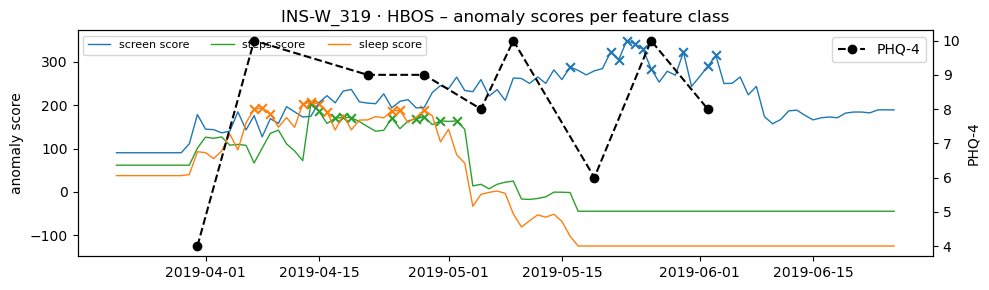

[✓] INS-W_319 – COPOD: 97 rows  ->  data/processed/anomaly_daily/INS-W_319_COPOD_multiblock.csv


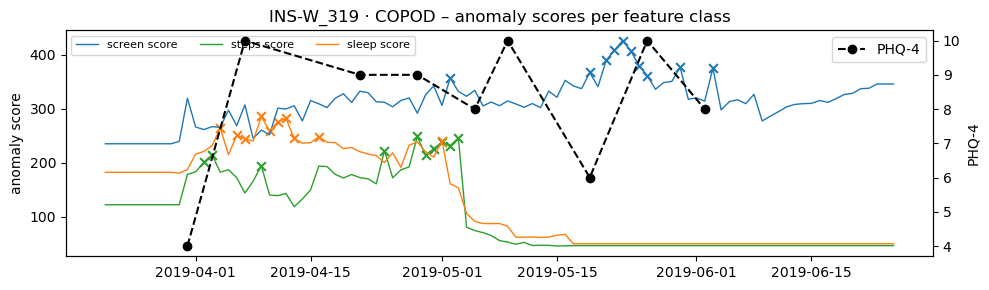

[✓] INS-W_326 – HBOS: 97 rows  ->  data/processed/anomaly_daily/INS-W_326_HBOS_multiblock.csv


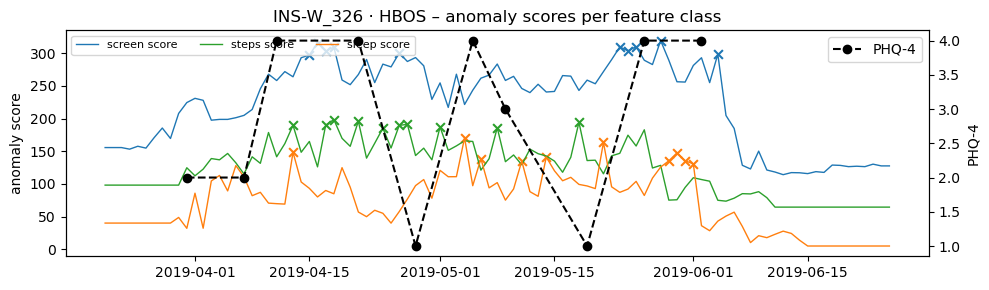

[✓] INS-W_326 – COPOD: 97 rows  ->  data/processed/anomaly_daily/INS-W_326_COPOD_multiblock.csv


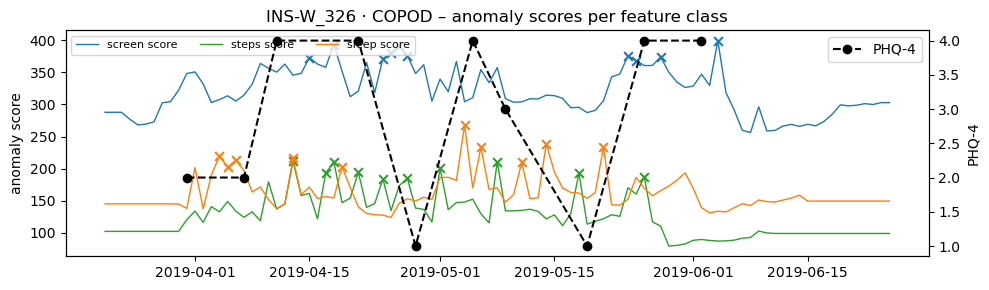

[✓] INS-W_343 – HBOS: 97 rows  ->  data/processed/anomaly_daily/INS-W_343_HBOS_multiblock.csv


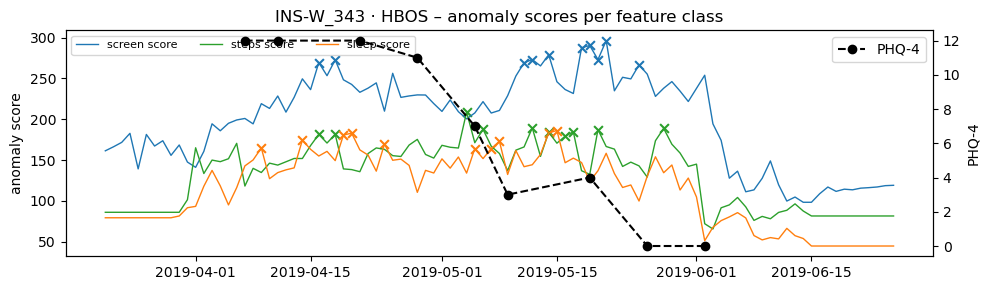

[✓] INS-W_343 – COPOD: 97 rows  ->  data/processed/anomaly_daily/INS-W_343_COPOD_multiblock.csv


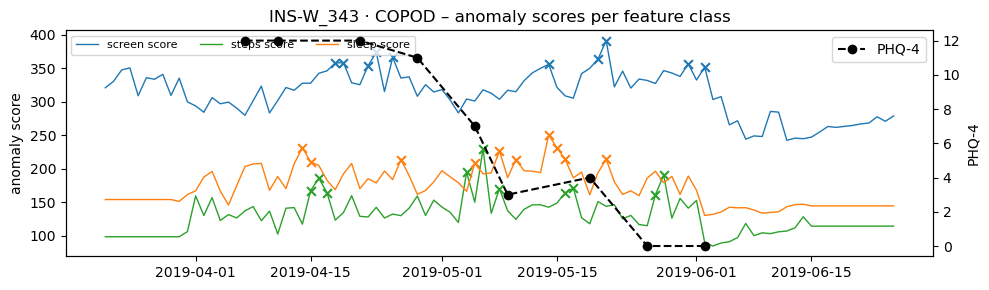

[✓] INS-W_359 – HBOS: 97 rows  ->  data/processed/anomaly_daily/INS-W_359_HBOS_multiblock.csv


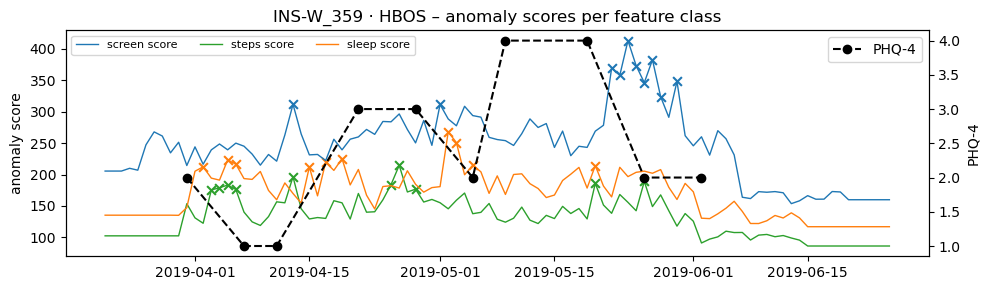

[✓] INS-W_359 – COPOD: 97 rows  ->  data/processed/anomaly_daily/INS-W_359_COPOD_multiblock.csv


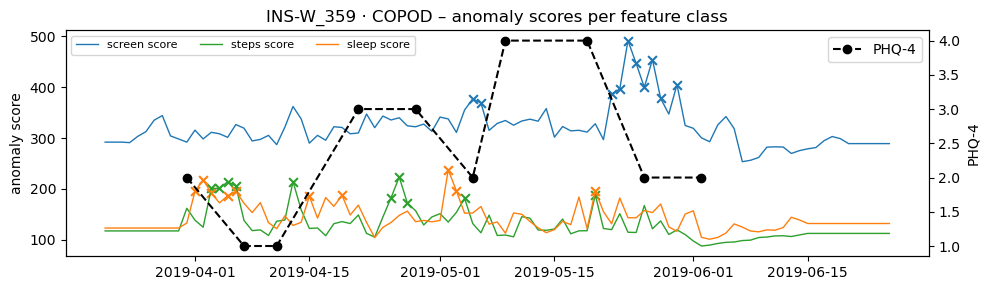

[✓] INS-W_366 – HBOS: 97 rows  ->  data/processed/anomaly_daily/INS-W_366_HBOS_multiblock.csv


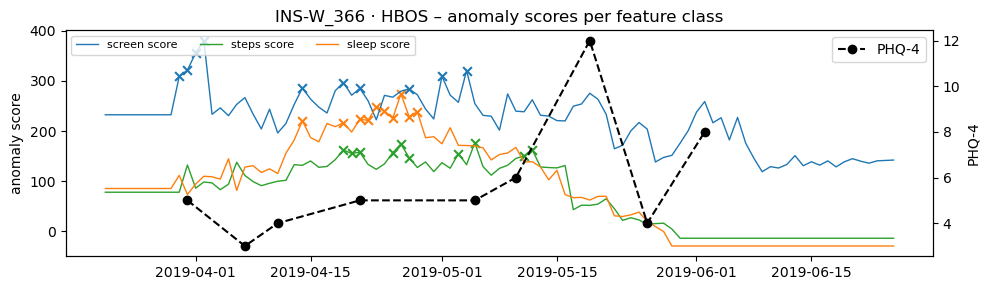

[✓] INS-W_366 – COPOD: 97 rows  ->  data/processed/anomaly_daily/INS-W_366_COPOD_multiblock.csv


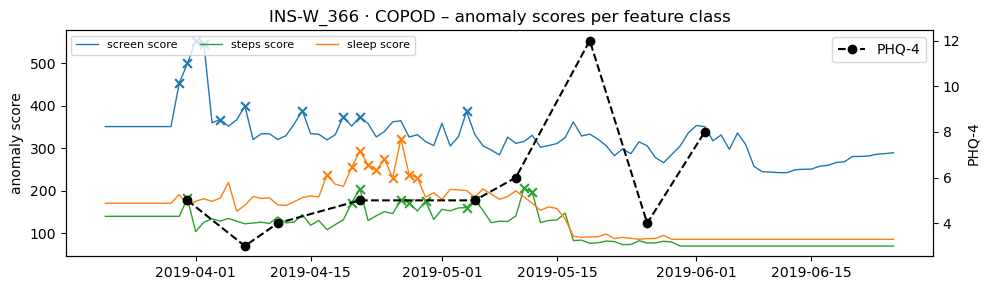

[✓] INS-W_375 – HBOS: 97 rows  ->  data/processed/anomaly_daily/INS-W_375_HBOS_multiblock.csv


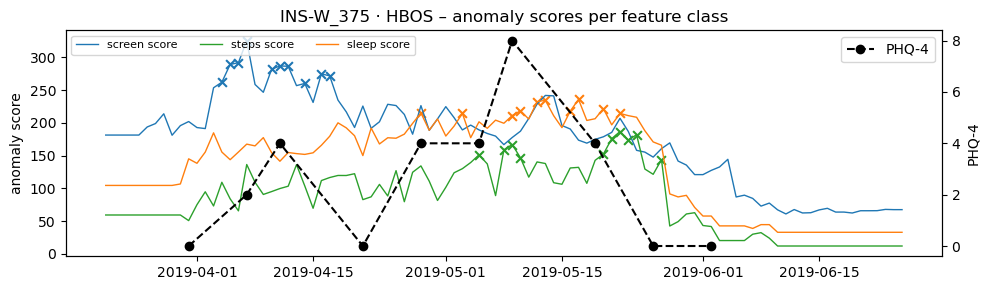

[✓] INS-W_375 – COPOD: 97 rows  ->  data/processed/anomaly_daily/INS-W_375_COPOD_multiblock.csv


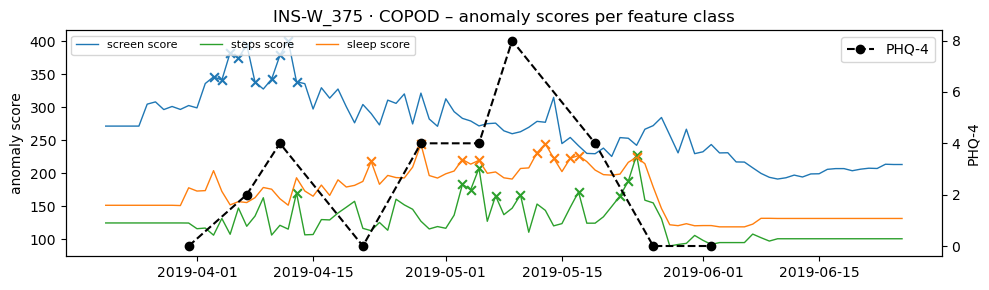

Done in 6.9s


In [9]:
DEMO_PIDS   = ["INS-W_319", "INS-W_326", "INS-W_343", "INS-W_359", "INS-W_366", "INS-W_375"]

# ------------------------------------------------------------------ #
# 2.  Build a cleaned *DataFrame* for one subject  (return df)
# ------------------------------------------------------------------ #
def get_daily_df(pid: str, folder: str = FOLDER) -> pd.DataFrame:
    feats = load_rapids(folder)
    df    = feats.loc[feats.pid == pid].copy()

    # keep wanted cols only
    good = df.columns.str.contains(INCLUDE_RE, regex=True)
    bad  = df.columns.str.contains(EXCLUDE_RE, regex=True)
    use_cols = df.columns[good & ~bad]

    if use_cols.empty:
        raise ValueError(f"No usable columns for {pid}")

    df = df[["date"] + use_cols.tolist()]
    df["date"] = pd.to_datetime(df["date"])
    df.sort_values("date", inplace=True)
    df.set_index("date", inplace=True)

    num = df.select_dtypes("number")

    # drop all-NaN cols, interpolate, fill remainder with median
    num = num.loc[:, ~num.isna().all()]
    num = num.interpolate("linear", limit_direction="both", axis=0)
    num = num.fillna(num.median())

    return num                            # rows = days, cols = numeric features


# ------------------------------------------------------------------ #
# 3.  Fit detector on a given feature subset
# ------------------------------------------------------------------ #
def detect_block(df_block: pd.DataFrame, model: str):
    if df_block.shape[1] == 0:           # no features in that class
        n = len(df_block)
        return np.full(n, np.nan), np.zeros(n, dtype=int)

    X   = RobustScaler().fit_transform(df_block.values)
    det = HBOS() if model.upper() == "HBOS" else COPOD()
    det.fit(X)
    return det.decision_scores_, det.labels_      # ← tuple!



# ------------------------------------------------------------------ #
# 4.  Main loop over subjects  (multi-block plotting)
# ------------------------------------------------------------------ #
COLOR = {"screen":"tab:blue", "steps":"tab:green", "sleep":"tab:orange"}

t0 = time.perf_counter()
for pid in DEMO_PIDS:
    try:
        df_daily = get_daily_df(pid)          # cleaned numeric DF
        dates    = df_daily.index.to_numpy()
    except Exception as e:
        print(f"[!] {pid} skipped – {e}")
        continue

    # prep PHQ-4
    phq = (load_labels(FOLDER)
           .loc[lambda d: d.pid == pid, ["date", "phq4"]]
           .assign(date=lambda d: pd.to_datetime(d.date))
           .sort_values("date"))
    phq_dates, phq_vals = phq["date"].to_numpy(), phq["phq4"].to_numpy()

    # column masks for three feature classes
    blocks = {
        "screen": df_daily.filter(regex=r"^f_screen:phone"),
        "steps" : df_daily.filter(regex=r"^f_steps:fitbit"),
        "sleep" : df_daily.filter(regex=r"^f_slp:fitbit"),
    }

    for model in ("HBOS", "COPOD"):
        # scores_dict now maps name → (scores, flags)
        scores_dict = {name: detect_block(block, model)
                       for name, block in blocks.items()}

        # ---------------- CSV -----------------------------------------
        out = pd.DataFrame({"date": dates})
        for name, (scores, flags) in scores_dict.items():
            out[f"{model}_{name}_score"] = scores
            out[f"{model}_{name}_flag"]  = flags
        csv_path = f"{OUTDIR}/{pid}_{model}_multiblock.csv"
        out.to_csv(csv_path, index=False)
        print(f"[✓] {pid} – {model}: {len(out)} rows  ->  {csv_path}")

        # ---------------- plot ----------------------------------------
        fig, ax = plt.subplots(figsize=(10, 3))
        for name, (scores, flags) in scores_dict.items():
            ax.plot(dates, scores, lw=1, color=COLOR[name], label=f"{name} score")
            ax.scatter(dates[flags == 1], scores[flags == 1],
                       marker="x", s=40, color=COLOR[name])

        # PHQ-4 on secondary axis
        ax2 = ax.twinx()
        ax2.plot(phq_dates, phq_vals, color="black",
                 marker="o", linestyle="--", label="PHQ-4")

        ax.set_title(f"{pid} · {model} – anomaly scores per feature class")
        ax.set_ylabel("anomaly score")
        ax2.set_ylabel("PHQ-4")
        ax.legend(loc="upper left", ncol=3, fontsize=8)
        ax2.legend(loc="upper right")
        fig.tight_layout()
        plt.show()


print(f"Done in {time.perf_counter()-t0:0.1f}s")


# Examine extracted anomaly events

In [12]:
import pandas as pd
anomaly_count_df = pd.read_csv("data/processed/phq4_anomaly_counts_HBOS.csv")
anomaly_count_df.head()

,pid,PHQ4_date,PHQ4,window_days,screen_count_flag,screen_prop_flag,steps_count_flag,steps_prop_flag,sleep_count_flag,sleep_prop_flag
0,INS-W_300,2019-04-07,3.0,7,0,0.000000,0,0.0,0,0.0
1,INS-W_300,2019-04-11,3.0,4,0,0.000000,0,0.0,0,0.0
2,INS-W_300,2019-04-21,5.0,10,0,0.000000,0,0.0,2,0.2
3,INS-W_300,2019-04-28,5.0,7,2,0.285714,0,0.0,0,0.0
4,INS-W_300,2019-05-05,2.0,7,0,0.000000,0,0.0,0,0.0


<Axes: >

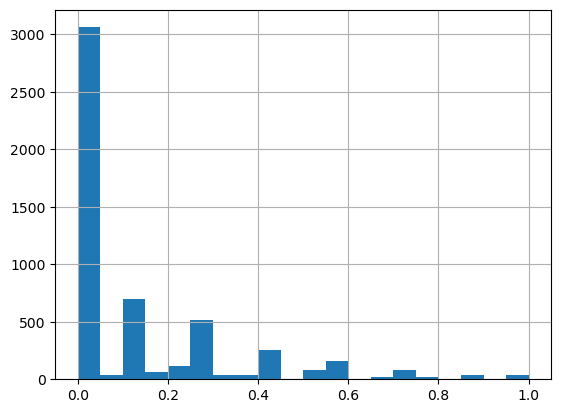

In [18]:
anomaly_count_df.sleep_prop_flag.hist(bins=20)

<Axes: >

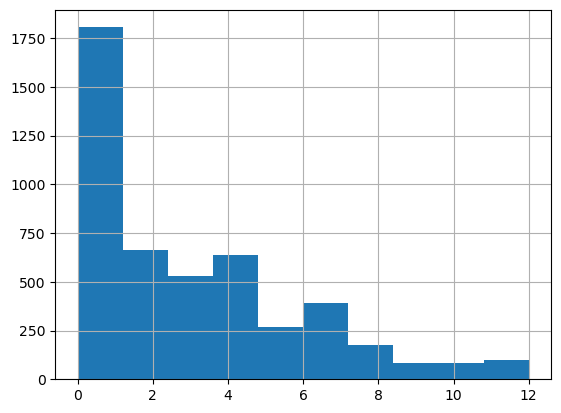

In [13]:
anomaly_count_df.PHQ4.hist()

In [23]:
# ================================================================
# 0.  Install/upgrade once (uncomment if needed)
# ------------------------------------------------
# !pip install --upgrade causal-learn pydot pandas

import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz          # Gaussian CI test
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils

# ================================================================
# 1.  Load data  --------------------------------------------------
# ------------------------------------------------
df = pd.read_csv("data/processed/phq4_anomaly_counts_HBOS.csv", parse_dates=["PHQ4_date"])

# ------------------------------------------------
# 2.  Derive PHQ4_dev  (Δ since previous survey) -
# ------------------------------------------------
df = df.sort_values(["pid", "PHQ4_date"])
df["PHQ4_dev"] = df.groupby("pid")["PHQ4"].diff()      # NaN for very first survey
df = df.dropna(subset=["PHQ4_dev"])                    # keep rows that have a Δ

# ----------------------------------------------------------------
# 2-bis.  Impute NaNs (subject mean, else population mean)
# ----------------------------------------------------------------
cols = ["PHQ4_dev", "screen_prop_flag", "steps_prop_flag", "sleep_prop_flag"]

for col in cols:
    # subject-level mean (ignores NaN)
    subj_mean = df.groupby("pid")[col].transform("mean")
    # fill NaN with subject mean
    df[col] = df[col].fillna(subj_mean)
    # if a subject had all NaN, subj_mean is still NaN → use population mean
    pop_mean = df[col].mean()
    df[col] = df[col].fillna(pop_mean)


# ================================================================
# 3.  Select variables & build NumPy matrix ----------------------
# ------------------------------------------------
cols = ["PHQ4_dev",
        "screen_prop_flag",
        "steps_prop_flag",
        "sleep_prop_flag"]
data = df[cols].to_numpy(dtype=float)                  # shape: (n_rows, 4)
labels = cols                                          # for later plots

# ================================================================
# 4-A.   PC (constraint-based)  ----------------------------------
# ------------------------------------------------
cg_pc = pc(data, alpha=0.05, indep_test=fisherz)       # CausalGraph object

# ================================================================
# 4-B.   GES (score-based)  --------------------------------------
# ------------------------------------------------
record_ges = ges(data)                                 # dict with keys 'G', 'score'
cg_ges = record_ges['G']

# ================================================================
# 5.  Export graphs as PNGs  -------------------------------------
# ------------------------------------------------
GraphUtils.to_pydot(cg_pc.G,  labels=labels).write_png("pc_graph.png")
GraphUtils.to_pydot(cg_ges,  labels=labels).write_png("ges_graph.png")
print("Done!  PC result → pc_graph.png,    GES result → ges_graph.png")


  0%|          | 0/4 [00:00<?, ?it/s]

Done!  PC result → pc_graph.png,    GES result → ges_graph.png


In [26]:
corr = df[cols].corr(method="pearson") 
corr

,PHQ4_dev,screen_prop_flag,steps_prop_flag,sleep_prop_flag
PHQ4_dev,1.000000,-0.003172,-0.003967,-0.015410
screen_prop_flag,-0.003172,1.000000,0.027598,0.000971
steps_prop_flag,-0.003967,0.027598,1.000000,0.188193
sleep_prop_flag,-0.015410,0.000971,0.188193,1.000000
